## Accessing Sentinel-1 RTC data with the Planetary Computer STAC API

The [Sentinel 1 RTC](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-rtc) product in this collection is a radiometrically terrain corrected product derived from the [Sentinel-1 Ground Range Detected (GRD)](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-grd) Level-1 products produced by the European Space Agency.

### Environment setup

Running this notebook requires an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

See [when an account is needed](https://planetarycomputer-staging.microsoft.com/docs/concepts/sas/#when-an-account-is-needed) for more, and [request an account](http://planetarycomputer.microsoft.com/account/request) if needed.

In [1]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table

from IPython.display import Image

### Choose an area and time of interest

We'll search for assets acquired over Panama in the first week of May, 2022. You can use the [Planetary Computer Explorer](https://planetarycomputer-staging.microsoft.com/explore?c=-79.6735%2C9.0461&z=9.91&ae=0&v=2&d=sentinel-1-rtc&s=false%3A%3A100%3A%3Atrue&m=Most+recent+-+VV%2C+VH&r=VV%2C+VH+False-color+composite) to find areas of interest.

In [2]:
bbox = [-80.11, 8.71, -79.24, 9.38]
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2022-05-02/2022-05-09"
)
items = search.get_all_items()
print(f"Found {len(items)} items")
item = items[0]

Found 3 items


The `rendered_preview` asset lets us quickly visualize the data. For Seninel-1 RTC, this produces a false-color composite from a combination of the VV and VH bands.

In [3]:
Image(url=item.assets["rendered_preview"].href)

### Inspect the STAC metadata

The STAC metadata includes many useful pieces of metadata, including metadata from the [SAR](https://github.com/stac-extensions/sar) and [Satellite](https://github.com/stac-extensions/sat) extensions.

In [4]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                        │
│ datetime                              │ 2022-05-04T23:32:10.313109Z                       │
│ end_datetime                          │ 2022-05-04 23:32:22.812028+00:00                  │
│ platform                              │ SENTINEL-1A                                       │
│ proj:bbox                             │ [519450.0, 935520.0, 800080.0, 1153060.0]         │
│ proj:epsg                             │ 32617                                             │
│ proj:shape                            │ [28806, 21907]                                    │
│ proj:transform                        │ [10.0, 0.0, 519430.0, 0.0, -10.0, 1154570.0, 0.0, │
│                                       │ 0.0, 1.0]                                         │
│ s1:datatake_id                        │ 337052                                            │
│ s1:instrument_configuration_ID        │ 7                                                 │
│ s1:orbit_source                       │ RESORB                                            │
│ s1:processing_level                   │ 1                                                 │
│ s1:product_timeliness                 │ Fast-24h                                          │
│ s1:resolution                         │ high                                              │
│ s1:shape                              │ [28806, 21907]                                    │
│ s1:slice_number                       │ 2                                                 │
│ s1:total_slices                       │ 29                                                │
│ sar:center_frequency                  │ 5.405                                             │
│ sar:frequency_band                    │ C                                                 │
│ sar:instrument_mode                   │ IW                                                │
│ sar:looks_azimuth                     │ 1                                                 │
│ sar:looks_equivalent_number           │ 4.4                                               │
│ sar:looks_range                       │ 5                                                 │
│ sar:observation_direction             │ right                                             │
│ sar:pixel_spacing_azimuth             │ 10                                                │
│ sar:pixel_spacing_range               │ 10                                                │
│ sar:polarizations                     │ ['VV', 'VH']                                      │
│ sar:product_type                      │ GRD                                               │
│ sar:resolution_azimuth                │ 22                                                │
│ sar:resolution_range                  │ 20                                                │
│ sat:absolute_orbit                    │ 43068                                             │
│ sat:orbit_state                       │ ascending                                         │
│ sat:platform_international_designator │ 2014-016A                                         │
│ sat:relative_orbit                    │ 121                                               │
│ start_datetime                        │ 2022-05-04 23:31:57.814190+00:00                  │
└───────────────────────────────────────┴───────────────────────────────────────────────────┘

The data assets on every Sentinel-1 RTC item will be some combination of `hh`, `hv`, `vh`, and `vv`. These represent the terrain-corrected gamma nought values of a signal transmitted in one polarization ("h" or "v") and received in another ("h" or "v"). The `sar:polarizations` field indicates which assets are available.

In [5]:
item.properties["sar:polarizations"]

['VV', 'VH']

### Visualize the assets

Next, we'll load the `vv` data into [xarray](https://xarray.pydata.org/) and plot the results. We'll use [Dask](http://dask.org/) to load the data in parallel. We're working with a small amount of data so we'll use a single machine. For larger datasets, see [Scaling with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/).

In [6]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

/user/taugspurger@microsoft.com/proxy/8787/status


In [7]:
import stackstac

ds = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32630, resolution=100
)
ds

<xarray.DataArray 'stackstac-2e3e323c36e17b0a0dfec05eb6da8753' (time: 3,
                                                                band: 2,
                                                                y: 4248, x: 4431)>
dask.array<fetch_raster_window, shape=(3, 2, 4248, 4431), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2022-05-04T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2022...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 -1.225e+07 ... -1.18e+07
  * y                                      (y) float64 4.171e+06 ... 3.746e+06
    sar:resolution_azimuth                 int64 22
    ...                                     ...
    sar:product_type                       <U3 'GRD'
    sar:pixel_spacing_range                int64 10
    title                                  (band) <U41 'VH: vertical transmit...
    description                            (band) <U173 'Terrain-corrected ga...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(-12247900, 3746300, -11804800...
    crs:         epsg:32630
    transform:   | 100.00, 0.00,-12247900.00|\n| 0.00,-100.00, 4171100.00|\n|...
    resolution:  100

We'll select the `vv` band for the first timestep found by our search.

In [8]:
vv = ds.sel(band="vv")[0].compute()

The distribution of the raw values is quite skewed:

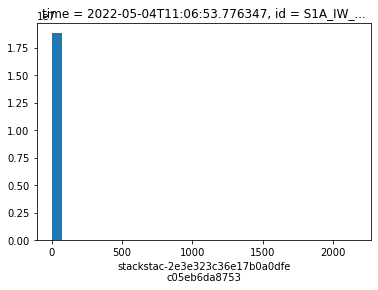

In [9]:
vv.plot.hist(bins=30);

So the values are typically transformed before visualization:

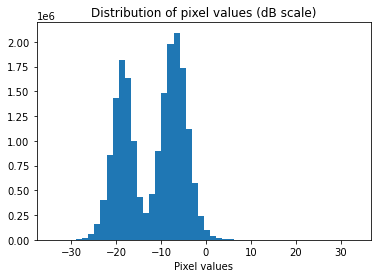

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))


def db_scale(x):
    return 10 * np.log10(x)


db_scale(vv).plot.hist(bins=50, ax=ax)
ax.set(title="Distribution of pixel values (dB scale)", xlabel="Pixel values");

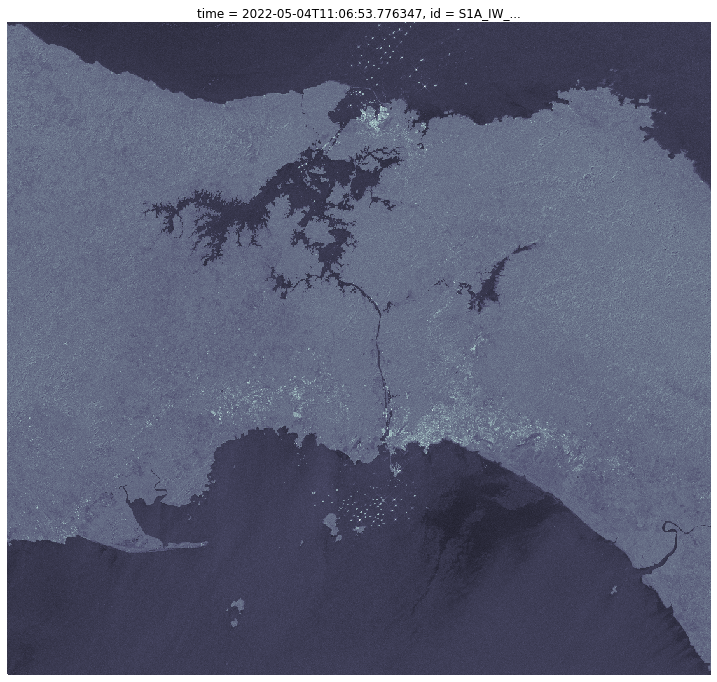

In [11]:
img = (
    db_scale(vv)
    .coarsen(x=4, y=4, boundary="trim")
    .max()
    .plot.imshow(cmap="bone", size=12, aspect=1.05, add_colorbar=False)
)
img.axes.set_axis_off();

### The effect of terrain correction

In this section, we compare Sentinel-1 GRD to Sentinel-1 RTC to see the effect of terrain correction.

Every Sentinel-1-RTC item is derived from a [Sentinel-1-GRD](https://planetarycomputer-staging.microsoft.com/dataset/sentinel-1-grd) item. You can follow the `derived_from` link to get back to the original GRD item.

In [12]:
(rtc_item,) = catalog.search(
    collections="sentinel-1-rtc",
    ids=["S1A_IW_GRDH_1SDV_20220518T054334_20220518T054359_043261_052A9D_rtc"],
).get_all_items()

grd_item = pystac.read_file(rtc_item.get_single_link("derived_from").target)

Next, we'll use the `tilejson` asset, which uses the Planetary Computer's [Data API](https://planetarycomputer.microsoft.com/api/data/v1/) to serve xyz tiles for a STAC item.

In [13]:
grd_tiles = requests.get(grd_item.assets["tilejson"].href).json()["tiles"][0]
rtc_tiles = requests.get(rtc_item.assets["tilejson"].href).json()["tiles"][0]

With these URLs, we can build an interactive map using [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html). Adjust the slider to visualize either GRD (to the left) or RTC (to the right).

In [14]:
center = [47.05, 7.10]
m = ipyleaflet.Map(
    center=center,
    zoom=14,
    controls=[ipyleaflet.FullScreenControl()],
)
grd_layer = ipyleaflet.TileLayer(url=grd_tiles)
rtc_layer = ipyleaflet.TileLayer(url=rtc_tiles)

control = ipyleaflet.SplitMapControl(left_layer=grd_layer, right_layer=rtc_layer)
m.add_control(control)
m.scroll_wheel_zoom = True
m

Map(center=[47.05, 7.1], controls=(FullScreenControl(options=['position']), ZoomControl(options=['position', '…

Notice that points seem to "jump" between the GRD and RTC. The RTC values are corrected to align with where they're actually at on the Earth.

For more background on terrain correction, and for an introduction to the [sarsen](https://github.com/bopen/sarsen) package which enables customizable RTCs, see [Sentinel-1 Customizable Radiometric Terrain Correction](https://planetarycomputer-staging.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/).